In [28]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
from scipy.stats import skew
from matplotlib import pyplot as plt

In [10]:
# Importing csv datasets into pandas' DataFrame
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

In [11]:
#take a look to the train set
train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


In [12]:
# In order to get better accuracy on the final prediction, I cut out the price column
# from the trainset and merge the two datasets together this result in a larger dataset and
# hopefully better estimations
whole_set = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                       test.loc[:, 'MSSubClass':'SaleCondition']))

In [13]:
# define a very simple function take a pandas' dataframe and remove
# any columns that exceed a certain ratio(default 1/2) of NaN among its entries.
def remove_nan(dataframe, threshold=1/2):
    size = len(dataframe)
    dataframe.dropna(thresh=size - np.floor(size*threshold), axis=1, inplace=True)

In [14]:
# check the dataset shape
whole_set.shape

(2919, 79)

In [16]:
#  apply remove_nan and remove all features that contains too many NaN
remove_nan(whole_set, threshold=0.4)

In [17]:
# check the shape again
whole_set.shape

(2919, 74)

In [18]:
# Since Kaggle evaluates submissions using the logarithm of the predicted value
# makes sense to train the model with the logarithm of the prices
train["SalePrice"] = np.log(train["SalePrice"])

In [19]:
# Extract numerical features
numeric_features = whole_set.dtypes[whole_set.dtypes != "object"].index
whole_set[numeric_features].head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008
6,50,85.0,14115,5,5,1993,1995,0.0,732.0,0.0,...,480.0,40,30,0,320,0,0,700,10,2009
7,20,75.0,10084,8,5,2004,2005,186.0,1369.0,0.0,...,636.0,255,57,0,0,0,0,0,8,2007
8,60,NaN,10382,7,6,1973,1973,240.0,859.0,32.0,...,484.0,235,204,228,0,0,0,350,11,2009
9,50,51.0,6120,7,5,1931,1950,0.0,0.0,0.0,...,468.0,90,0,205,0,0,0,0,4,2008


In [20]:
#   Two function to detect and remove dataset entries that are identified as outliers,
#   it can be tuned with a threshold parameter. detect_outliers take in input a dataframe
#   and a threshold and return two list, each containing the outliers of trainset and testset
def detect_outliers(df, std_thresh=5):
    index_train = set()
    index_test = set()
    for feature in df.columns:
        mean = np.mean(df[feature].values)
        std = np.std(df[feature].values)
        for index, value in df[feature].iteritems():
            if np.abs((value - mean)/std) > std_thresh:
                if index <= 1460:
                    index_train.add(index)
                else:
                    index_test.add(index)
    return list(index_train), list(index_test)


#   Very simple function that take in input a pandas' dataframe and a list of outliers
#   return the dataframe with rows corresponding to the outliers ID dropped
def remove_outliers(df, outlier_list):
    tuned_list = []
    for x in outlier_list:
        tuned_list.append(x-1)
    return df.drop(df.index[tuned_list], axis=0)

In [21]:
# check the dataset shape
whole_set.shape

(2919, 74)

In [23]:
# remove outliers distinguishing from train set and test set
outliers_train, outliers_test = detect_outliers(whole_set[numeric_features])
whole_set = remove_outliers(whole_set, outliers_train)
train = remove_outliers(train, outliers_train)

In [24]:
# check the dataset shape
whole_set.shape

(2846, 74)

In [25]:
#   function compute_skewness take a pandas' dataframe and computes the skewness for each columns,
#   return a pandas' Series containing the skewness indexed with columns names.
def compute_skewness(dataframe):
    skewness = []
    for column in dataframe:
        skewness.append(skew(dataframe[column].dropna()))
    s = pd.Series(skewness, index=dataframe.columns)
    return s


#   Utility function to use paired with compute_skewness, select the skewed features according to
#   threshold(skew_thresh) specified
def select_skewed_features(series, skew_thresh=0.75):
    skewed = []
    for col in series.index:
        if series[col] > skew_thresh:
            skewed.append(col)
    return skewed

In [29]:
# Here we are computing the skewness of the samples, if it's bigger than a specific
# threshold I will transform the features by applying log(feature + 1)
skewness_arr = compute_skewness(train[numeric_features])
skewed_features = select_skewed_features(skewness_arr)
whole_set[skewed_features] = np.log1p(whole_set[skewed_features])

In [30]:
# Generate dummy variables from the remaining categorical variables
whole_set = pd.get_dummies(whole_set)

In [31]:
whole_set.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,706.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,978.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,486.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,216.0,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,655.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,3.044522,4.330733,9.218804,8,5,2004,2005,5.231109,1369.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,4.110874,NaN,9.247925,7,6,1973,1973,5.484797,859.0,3.496508,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,3.931826,3.951244,8.719481,7,5,1931,1950,0.000000,0.0,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
10,5.252273,3.931826,8.912069,5,6,1939,1950,0.000000,851.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
# Filling NaN values with the mean of the column this actually allows to compute regression even with points
# that include some NaN and at the same time avoids to introduce distorsions.
whole_set = whole_set.fillna(whole_set.mean())

In [33]:
whole_set.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,706.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,978.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,486.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,216.0,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,655.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,3.044522,4.330733,9.218804,8,5,2004,2005,5.231109,1369.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,4.110874,4.191866,9.247925,7,6,1973,1973,5.484797,859.0,3.496508,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,3.931826,3.951244,8.719481,7,5,1931,1950,0.000000,0.0,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
10,5.252273,3.931826,8.912069,5,6,1939,1950,0.000000,851.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
# Creating matrices and prediction vector to generate model
X = whole_set[:train.shape[0]]
X_test = whole_set[train.shape[0]:]
y = train.SalePrice

In [35]:
#   This function search the optimum alpha for the lasso regression,
#   at any step try with a different alpha and compute a cross validation on the dataset.
#   Is taken the alpha with max cross validation score associated.
#   The function take a train set X, a test vector y (with the sale prices) and as an optional parameter
#   an array containing alphas to try.

def opt_alpha_cv(X, y, test_range=np.arange(0.0002, 0.0005, 0.00001)):
    r2_arr = []
    alpha_arr = []
    for alpha in test_range:
        ridge_model = Lasso(alpha).fit(X, y)
        current_r2 = cross_val_score(ridge_model, X, y).mean()
        r2_arr.append(current_r2)
        alpha_arr.append(alpha)
    opt_alpha_idx = np.argmax(r2_arr)
    opt_alpha = alpha_arr[opt_alpha_idx]
    r2_min = r2_arr[opt_alpha_idx]
    return alpha_arr, r2_arr, opt_alpha, r2_min

In [36]:
#   Function used to plot the R^2 with respect of alpha of the Lasso model and Ridge model

def pplot(data, dotx, doty):
    plt.rcParams['figure.figsize'] = (12.0, 6.0)
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots()
    ax.plot(data, linewidth=3, c="c")
    ax.plot(dotx, doty, 'ro')
    ax.annotate(r'$max(R^2)='+str(np.round(doty, decimals=4))+'$', xy=(dotx, doty), xytext=(-20, 20),
                textcoords='offset points', ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.6),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.grid(True)
    plt.title('Cross Validation Lasso Model')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$R^2$')
    plt.xlim([0.0001, 0.0025])
    plt.ylim([0.910, 0.927])

    ticklines = ax.get_xticklines() + ax.get_yticklines()
    gridlines = ax.get_xgridlines() + ax.get_ygridlines()
    ticklabels = ax.get_xticklabels() + ax.get_yticklabels()

    for line in ticklines:
        line.set_linewidth(3)

    for line in gridlines:
        line.set_linestyle('-.')

    for label in ticklabels:
        label.set_color('k')
        label.set_fontsize('medium')

    plt.show()

In [38]:
# Generate arrays to plot R^2 with respect of alpha
test_range = np.arange(0.0001, 0.003, 0.00001)
alpha_arr, r2_arr, opt_alpha, r2max = opt_alpha_cv(X, y, test_range=test_range)
cv_lasso = pd.Series(r2_arr, index=alpha_arr)

C:\Users\aformichetti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
C:\Users\aformichetti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


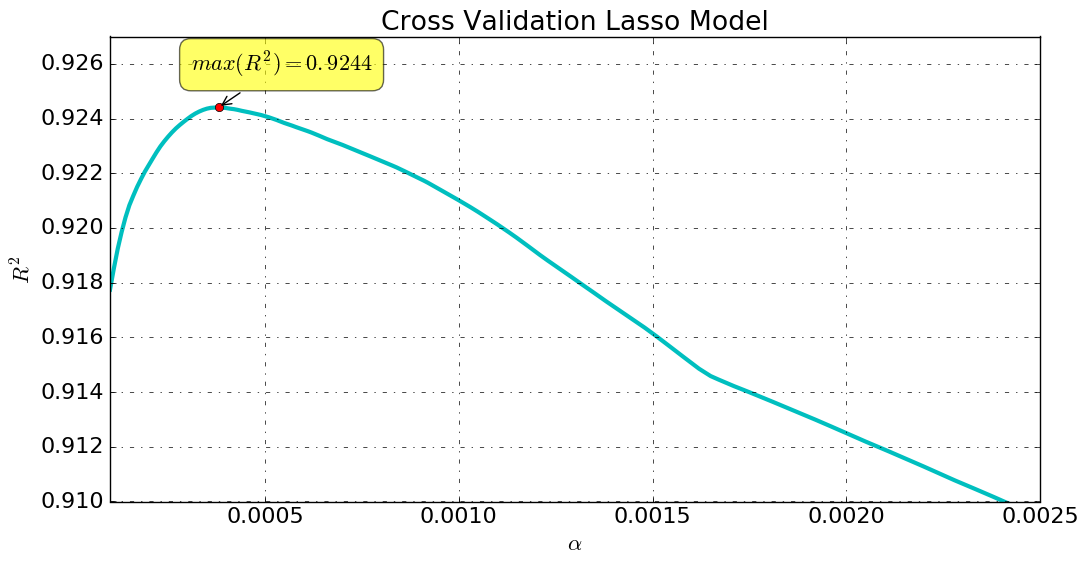

In [40]:
# plot the cross validation score (function of alpha)
pplot(cv_lasso, opt_alpha, r2max)

In [43]:
# Computing optimum alpha through a cross validation process
opt_alpha = opt_alpha_cv(X, y)[2]
opt_alpha

0.00038000000000000002

In [44]:
# Instance the Lasso model
lasso = Lasso(alpha=opt_alpha, fit_intercept=True)

In [45]:
# Fit data
lasso.fit(X, y)

Lasso(alpha=0.00038000000000000002, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

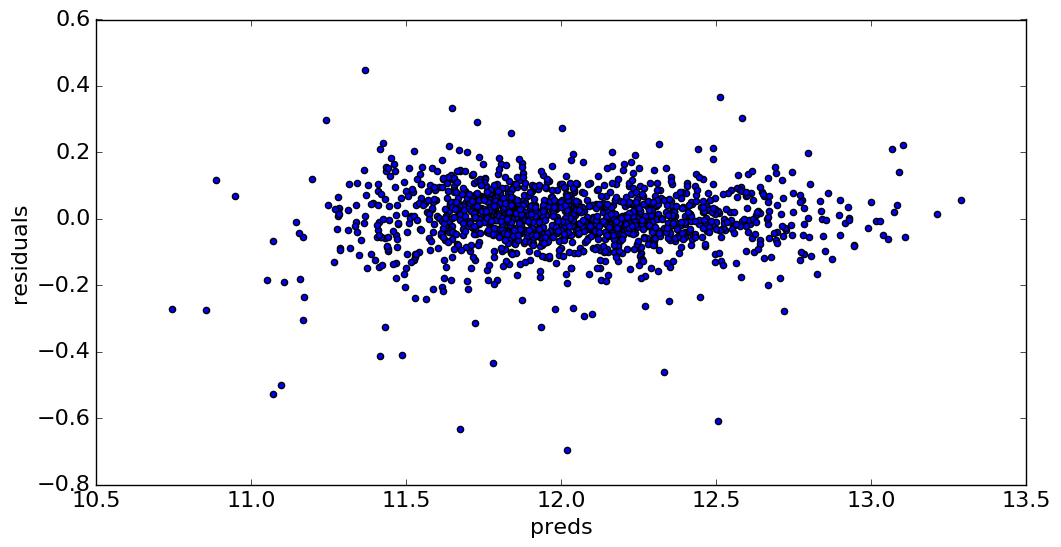

In [50]:
#let's look at the residuals
preds = pd.DataFrame({"preds":lasso.predict(X), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.show()

In [51]:
# Finally compute the prediction!
pred = pd.DataFrame({"SalePrice": np.exp(lasso.predict(X_test))}, index=test.index)
pred.to_csv("pred.csv")

In [52]:
#take a look at the predictions!
test = pd.read_csv("pred.csv", index_col=0)
test.head(20)

,SalePrice
Id,
1461,124729.249070
1462,157099.273080
1463,184712.199756
1464,200423.547652
1465,197695.605142
1466,172020.911359
1467,181999.972658
1468,160680.391789
1469,193364.468108
